In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 15000
stock = '9061'
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1)]

In [3]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, 
        gdf_filename_pattern=gdf_filename_pattern))

## Visualization

What do I want to say here?

* that data is quite random
* distribution of queue imbalance
* that there is some correlation between queue imbalance and mid price indicator 
* show some gdf values

In [4]:
df = gdf_dfs[2].df

### Mid Price

Data is quite random, there are outliers

Text(0.5,1,'Mid-Price for 9061 for training dataset')

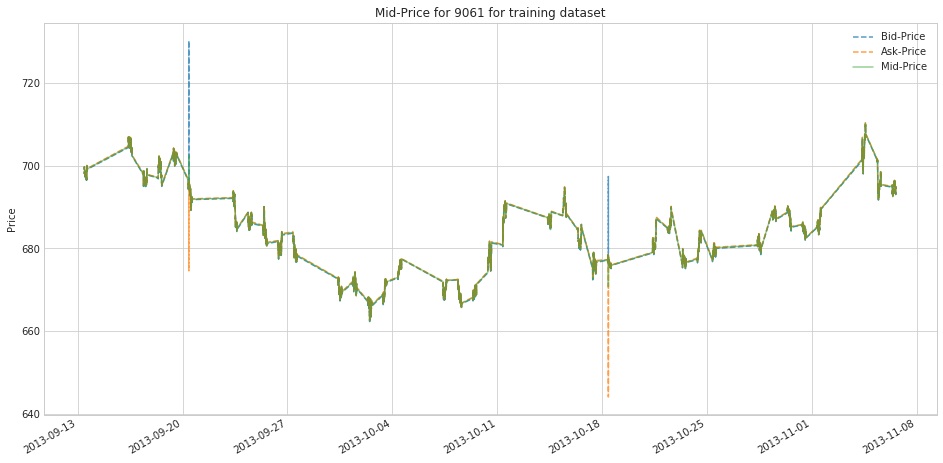

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))

df[['bid_price']].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].plot(ax=ax, alpha=0.5)
plt.legend(['Bid-Price', 'Ask-Price', 'Mid-Price',])
plt.ylabel('Price')
plt.xlabel('')
plt.title('Mid-Price for 9061 for training dataset')

We can observe outliers, lets look into them - both are around 11 Fridays

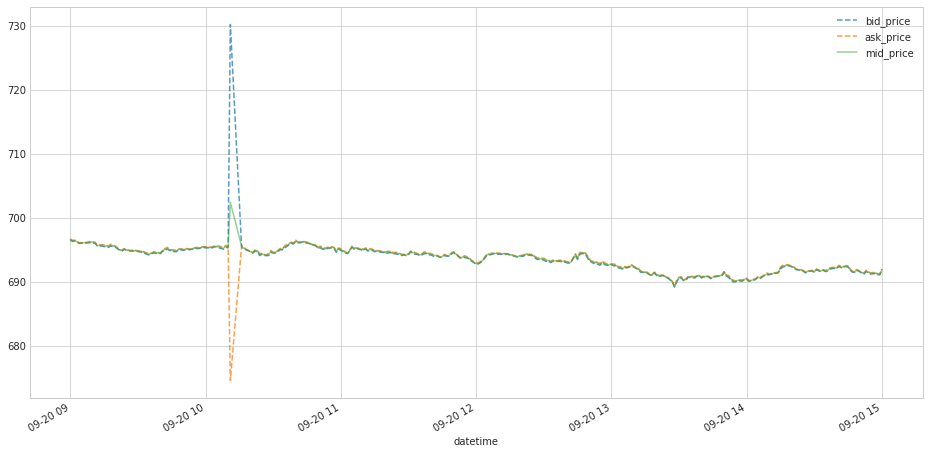

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
df[['bid_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.5)

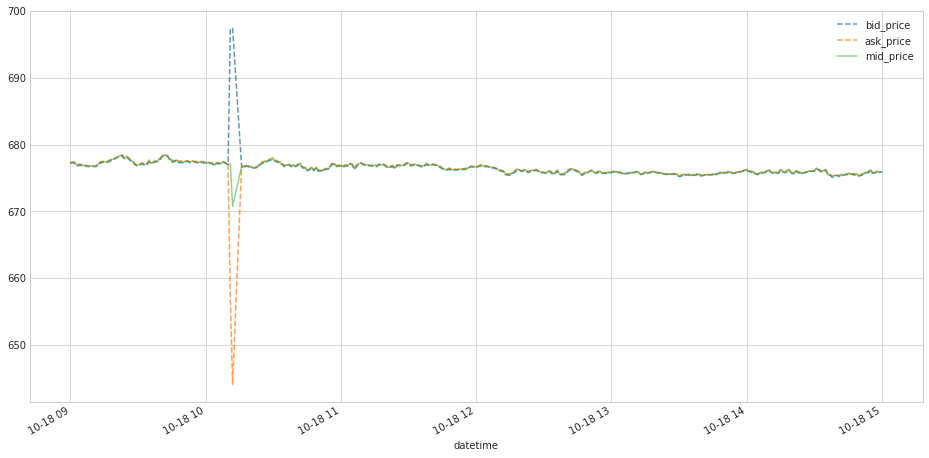

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
df[['bid_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.5)

### Distributions 

(684.0024168680709, 683.7, 0    679.9
 1    680.2
 dtype: float64)

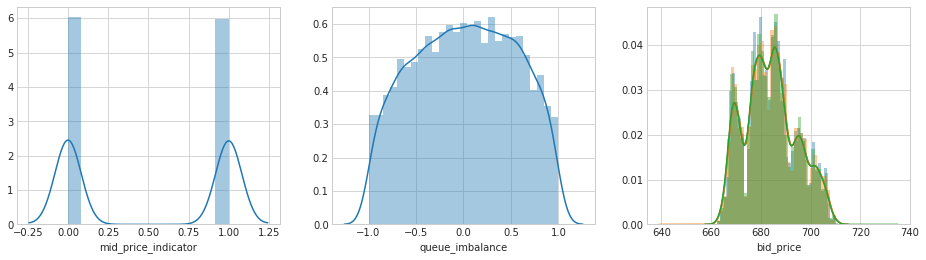

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.distplot(df['mid_price_indicator'], ax=ax[0])
sns.distplot(df['queue_imbalance'], ax=ax[1])
sns.distplot(df['mid_price'], ax=ax[2])
sns.distplot(df['ask_price'], ax=ax[2])
sns.distplot(df['bid_price'], ax=ax[2])
df['mid_price'].mean(), df['mid_price'].median(), df['mid_price'].mode()

Distribution of Mid-Price Indidcator is balanced (classes are balanced). Mid-Price distribution is slightly Right-Skewed.

(684.0024168680709, 683.7, 0    679.9
 1    680.2
 dtype: float64)

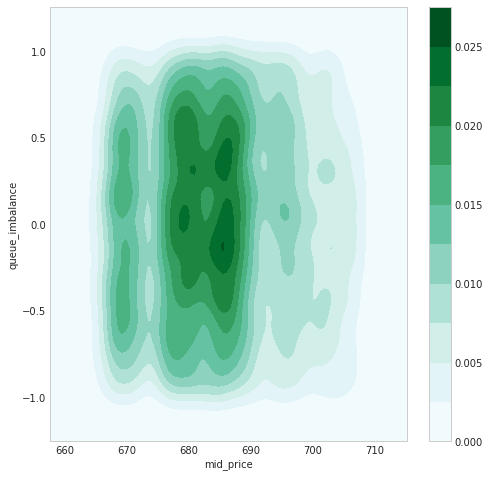

In [9]:
plt.figure(figsize=(8, 8))
sns.kdeplot(df['mid_price'], df['queue_imbalance'], cbar=True, shade=True)
df['mid_price'].mean(), df['mid_price'].median(), df['mid_price'].mode()

We can see that for queue imbalance -1 or 1 the density is the smallest. The highest density for queue imbalance in between -0.5 and 0.5 which happens to be around the mean mid price

### Correlations

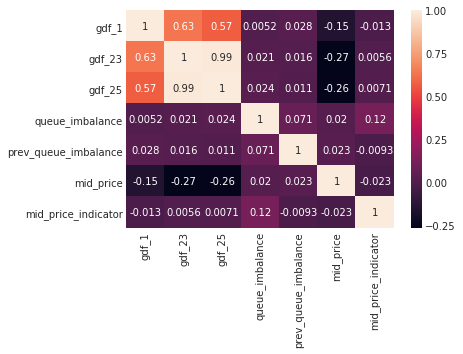

In [10]:
cols = ['gdf_1', 'gdf_23', 'gdf_25', 'queue_imbalance', 'prev_queue_imbalance', 
        'mid_price', 'mid_price_indicator']
sns.heatmap(df[cols].corr(), annot=True)
# TODO: ?

In [11]:
### GDF

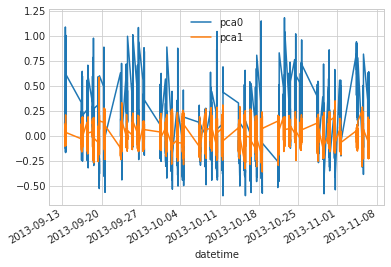

In [12]:
n_components = 2
pca = PCA(n_components=n_components)
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]
p = pca.fit_transform(df[gdf_columns])

for i in range(n_components):
    df['pca' + str(i)] = p[:, i]
pca_cols = ['pca' + str(i) for i in range(n_components)]

cols = ['gdf_23', 'gdf_25', 'queue_imbalance',
        'mid_price', 'mid_price_indicator']
df[pca_cols].plot()

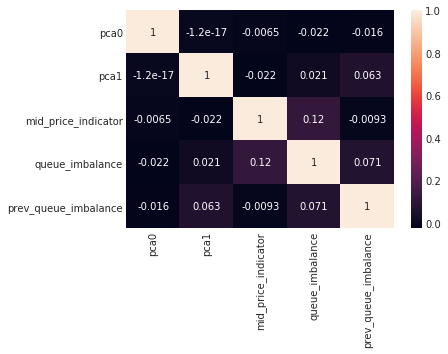

In [31]:

sns.heatmap(df[pca_cols + [
    'mid_price_indicator', 'queue_imbalance', 'prev_queue_imbalance']].corr(), annot=True)

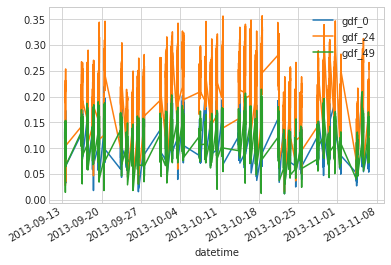

In [14]:
df[['gdf_0', 'gdf_24', 'gdf_49']].plot()

Text(0.5,1,'0.0')

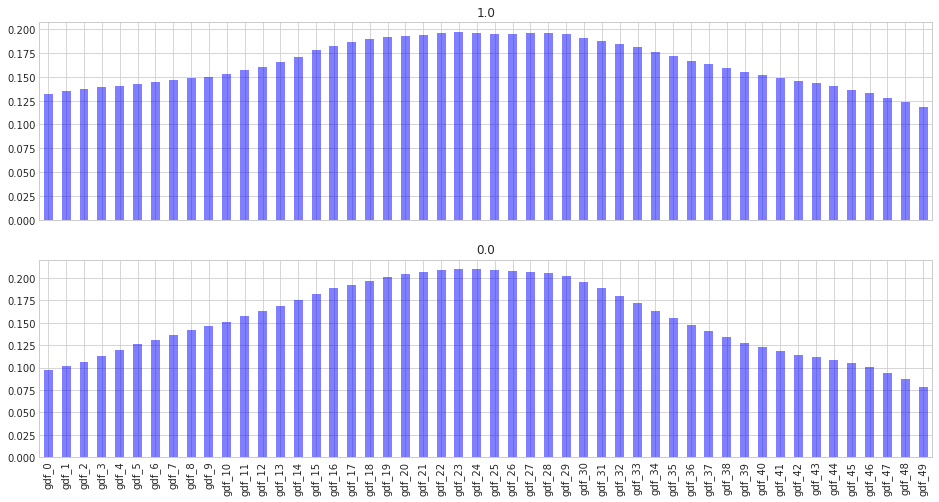

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
df[gdf_columns].iloc[0].plot('bar', color=['b'], alpha=0.5, ax=ax[0])
df[gdf_columns].iloc[2003].plot('bar', color=['b'], alpha=0.5, ax=ax[1])
ax[0].set_title(df['mid_price_indicator'].iloc[0])
ax[1].set_title(df['mid_price_indicator'].iloc[2003])

Text(0.5,1,'0.0')

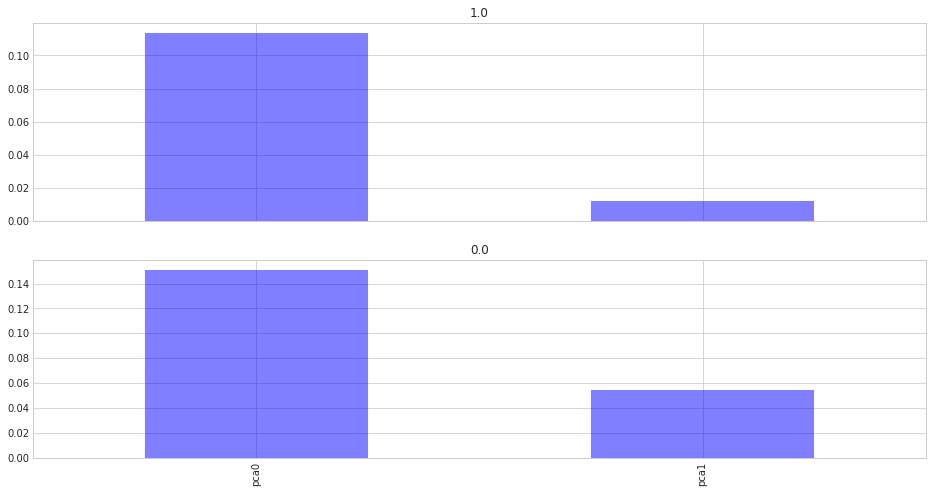

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
df[pca_cols].iloc[0].plot('bar', color=['b'], alpha=0.5, ax=ax[0])
df[pca_cols].iloc[2003].plot('bar', color=['b'], alpha=0.5, ax=ax[1])
ax[0].set_title(df['mid_price_indicator'].iloc[0])
ax[1].set_title(df['mid_price_indicator'].iloc[2003])

In [17]:
df.head()

,Unnamed: 0,gdf_0,gdf_1,gdf_10,gdf_11,gdf_12,gdf_13,gdf_14,gdf_15,gdf_16,...,gdf_9,mid_price,mid_price_indicator,datetime,bid_price,ask_price,queue_imbalance,prev_queue_imbalance,pca0,pca1
datetime,,,,,,,,,,,,,,,,,,,,,
2013-09-13 10:37:00,3001,0.132015,0.134891,0.153184,0.157158,0.160683,0.164990,0.170649,0.177738,0.182436,...,0.150132,699.20,1.0,2013-09-13 10:37:00,699.1,699.3,-0.438189,0.399368,0.113851,0.011712
2013-09-13 10:39:00,3002,0.129575,0.135761,0.153909,0.157819,0.161154,0.164812,0.169690,0.173651,0.178259,...,0.151183,699.45,0.0,2013-09-13 10:39:00,699.4,699.5,0.073354,-0.438189,0.117694,0.013710
2013-09-13 10:40:00,3003,0.127869,0.133657,0.147317,0.150291,0.154388,0.158469,0.163804,0.169987,0.176215,...,0.145548,699.40,1.0,2013-09-13 10:40:00,699.3,699.5,0.394028,0.073354,0.119963,-0.003322
2013-09-13 10:41:00,3004,0.138358,0.140774,0.156609,0.161249,0.166716,0.173128,0.179832,0.185545,0.191385,...,0.153254,699.55,0.0,2013-09-13 10:41:00,699.5,699.6,0.777939,0.394028,0.132513,0.065007
2013-09-13 10:42:00,3005,0.125554,0.131329,0.152172,0.155975,0.160595,0.164467,0.168663,0.174242,0.181122,...,0.149266,699.25,1.0,2013-09-13 10:42:00,699.1,699.4,-0.160485,0.777939,0.126013,0.034029


Text(0,0.5,'')

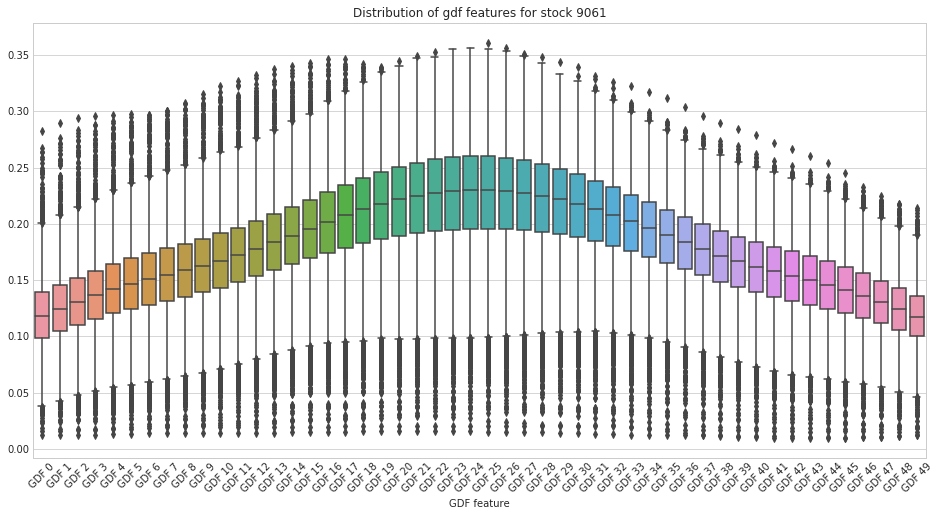

In [18]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=df[gdf_columns])

_ = ax.set_xticklabels([g.replace('_', ' ').upper() for g in gdf_columns], rotation=45)

plt.title('Distribution of gdf features for stock ' + str(stock))
plt.xlabel('GDF feature')
plt.ylabel('')

Text(0,0.5,'')

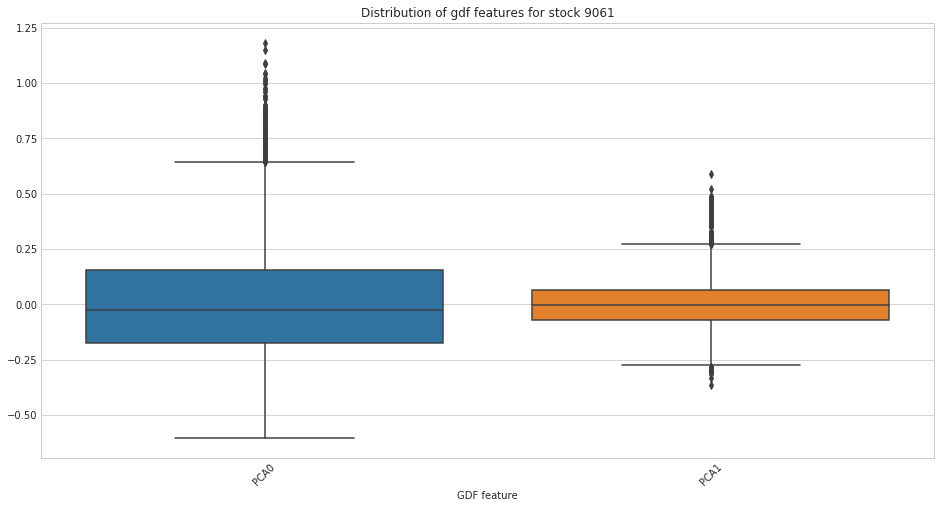

In [19]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=df[pca_cols])

_ = ax.set_xticklabels([g.replace('_', ' ').upper() for g in pca_cols], rotation=45)

plt.title('Distribution of gdf features for stock ' + str(stock))
plt.xlabel('GDF feature')
plt.ylabel('')

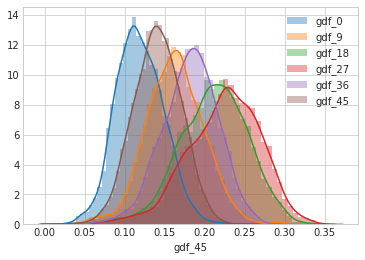

In [20]:
for g in gdf_columns[::9]:
    sns.distplot(df[g], label=g)
plt.legend()

## Predictions

In [72]:
def get_kernel_from_method(method):
    return method.split('_')[1]

class CFR():
    def __init__(self, clf, feature_name, is_svm=True):
        self.clf = clf
        self.feature_name = feature_name
        self.is_svm = is_svm

    def get_result(self, gdf_df, should_validate=False, method=None):
        if self.is_svm:
            return gdf_df.train_svm(C=self.clf.C, gamma=self.clf.gamma, coef0=self.clf.coef0, 
                                    kernel=self.clf.kernel, 
                                    feature_name=self.feature_name, should_validate=should_validate)
        else:
            res = gdf_df.train_log(self.clf, self.feature_name, should_validate=should_validate)
            if method:
                res['kernel'] = method
            return res

### Queue Imbalance - LOGIT, SVM (linear, rbf, sigmoid)

In [22]:
def get_best_svm_results_for_queue_imbalance(s, features):
    df_res = pd.read_csv('res_{}_prev_queue_imbalance.csv'.format(s))
    df_res= df_res[df_res['features'] == features]
    df_res= df_res[df_res['method'] != 'logistic']
    df_res['stock'] = [s for i in range(len(df_res))]
    columns_to_mean = ['f1', 'kappa', 'matthews', 
       'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']
    for c in columns_to_mean:
        cc = []
        for i, row in df_res.iterrows():
            from ast import literal_eval
            cc.append(np.array(literal_eval(row[c])).mean())
        df_res[c] = cc

    return df_res.sort_values(by='matthews', ascending=False).groupby('method').head(1)

In [23]:
df_best_svm_que = get_best_svm_results_for_queue_imbalance(stock, features='queue_imbalance')

In [24]:
log_que_clfs = [
    CFR(clf=LogisticRegression(), feature_name='que', is_svm=False),
]

svm_que_clfs = [
    CFR(
        SVC(kernel=get_kernel_from_method(row['method']), 
            C=row['c'], 
            gamma=row['gamma'], 
            coef0=row['coef0']), feature_name='que') 
                for i, row in df_best_svm_que.iterrows()]


In [25]:
res = []
for clf in log_que_clfs + svm_que_clfs:
    r = clf.get_result(gdf_dfs[0])
    res.append(r)
df_res_que = pd.DataFrame(res)
df_res_que

,C,coef0,features,gamma,kernel,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,NaN,NaN,que,NaN,logistic,9061,0.517040,0.063960,0.064032,0.529993,0.504704,0.531968,0.544324,0.096045,0.096048,0.546482,0.542183,0.548021
1,10.0,NaN,que,0.10,rbf,9061,0.513176,0.063192,0.063311,0.530086,0.497312,0.531581,0.541914,0.098154,0.098180,0.548321,0.535655,0.549072
2,10.0,1.0,que,0.01,sigmoid,9061,0.530323,0.070264,0.070265,0.531757,0.528898,0.535131,0.552649,0.093708,0.093765,0.543352,0.562270,0.546861
3,100.0,NaN,que,NaN,linear,9061,0.527353,0.072146,0.072164,0.533333,0.521505,0.536067,0.549917,0.095313,0.095330,0.544857,0.555072,0.547660


### Queue Imbalance and Prev Queue Imbalance

In [26]:
df_best_svm_prev_que = get_best_svm_results_for_queue_imbalance(
    stock, features='queue_imbalance, prev_queue_imbalance')

In [27]:
prev_que_log_clfs = [
    CFR(clf=LogisticRegression(), feature_name='que_prev', is_svm=False),
]

svm_prev_que_clfs = [
    CFR(
        SVC(kernel=get_kernel_from_method(row['method']), 
            C=row['c'], 
            gamma=row['gamma'], 
            coef0=row['coef0']), feature_name='que_prev') 
                for i, row in df_best_svm_prev_que.iterrows()]

In [28]:
res = []
for clf in prev_que_log_clfs + svm_prev_que_clfs:
    r = clf.get_result(gdf_dfs[0])
    res.append(r)
df_res_que_prev = pd.DataFrame(res)
df_res_que_prev

,C,coef0,features,gamma,kernel,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,NaN,NaN,que_prev,NaN,logistic,9061,0.519848,0.071928,0.072028,0.534422,0.506048,0.535949,0.543542,0.095701,0.095707,0.546439,0.540676,0.547849
1,10.0,NaN,que_prev,0.10,rbf,9061,0.517444,0.067915,0.068015,0.532338,0.503360,0.533944,0.543596,0.099504,0.099521,0.548789,0.538500,0.549748
2,0.1,NaN,que_prev,NaN,linear,9061,0.530529,0.076839,0.076853,0.535616,0.525538,0.538414,0.550890,0.096156,0.096178,0.545157,0.556746,0.548082
3,10.0,0.1,que_prev,0.01,sigmoid,9061,0.531663,0.077530,0.077539,0.535836,0.527554,0.538760,0.551946,0.096505,0.096536,0.545143,0.558922,0.548258


### GDF Plain

In [29]:
df_gdf_plain_res = pd.DataFrame()
gdf_results_dir = '../gaussian_filter/data_res_9061_len15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if '9061' in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_plain_res = df_gdf_plain_res.append(temp_df)
print(df_gdf_plain_res.columns)
df_gdf_plain_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(1)

Index(['Unnamed: 0', 'C', 'coef0', 'f1', 'features', 'gamma', 'kappa',
       'kernel', 'matthews', 'precision', 'recall', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_precision',
       'test_recall', 'test_roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc'],
      dtype='object')


,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
32,32,10.000,NaN,0.322123,gdf_23-27,10.0,0.031676,rbf,0.041847,0.441331,...,0.05433,0.539181,0.309812,0.524529,0.313378,0.034542,0.039485,0.414109,0.294915,0.517164
0,0,0.001,NaN,0.068039,gdf_23-27,NaN,0.000000,linear,0.000000,0.049032,...,0.00000,0.000000,0.000000,0.500000,0.074795,0.000000,0.000000,0.056371,0.111111,0.500000


In [30]:
from sklearn.neural_network import MLPClassifier
alphas = [0.0001, 0.001, 0.1, 1.0]
hidden_layer_sizes = [(14, 6)]

res = []

for hidden_layer_size in hidden_layer_sizes:
    for alpha in alphas:
        solver = 'adam'
        activation = 'tanh'
        clf = MLPClassifier(solver=solver, alpha=alpha, activation=activation,
                            hidden_layer_sizes=hidden_layer_size, random_state=1)

        c = CFR(clf=clf, feature_name='gdf_0_50', is_svm=False)
        r = c.get_result(gdf_dfs[0], should_validate=True, method='mlp')
        res.append({**r, 'hidden_layer_size': hidden_layer_size, 
                    'alpha': alpha, 'activation': activation, 'solver': solver})
df_res1 = pd.DataFrame(res).sort_values(by='matthews', ascending=False)

NameError: name 'length' is not defined

### GDF with PCA

In [32]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca_gdf3_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
44,44,1000.0,NaN,0.475939,pca_gdf_que3,0.10,0.099728,rbf,0.106398,0.568105,...,0.053432,0.530450,0.403898,0.525907,0.473344,0.089494,0.092392,0.548413,0.420686,0.544461
44,44,1000.0,NaN,0.475713,pca_gdf_que3,0.10,0.099137,rbf,0.105778,0.567538,...,0.052748,0.530035,0.403226,0.525571,0.472663,0.088207,0.091086,0.547594,0.420282,0.543820
4,4,10.0,NaN,0.536470,pca_gdf_que3,NaN,0.099221,linear,0.100711,0.548814,...,0.066769,0.530924,0.513441,0.533358,0.534284,0.091488,0.091534,0.535875,0.532933,0.545717
4,4,10.0,NaN,0.535917,pca_gdf_que3,NaN,0.098294,linear,0.099675,0.548193,...,0.066756,0.531010,0.512097,0.533348,0.533404,0.090229,0.090268,0.535328,0.531696,0.545087
18,18,100.0,0.01,0.538234,pca_gdf_que3,0.01,0.097689,sigmoid,0.099004,0.547247,...,0.067440,0.531250,0.514113,0.533694,0.534554,0.090231,0.090269,0.535095,0.534213,0.545093
18,18,100.0,0.01,0.538215,pca_gdf_que3,0.01,0.097141,sigmoid,0.098463,0.546878,...,0.069466,0.532135,0.517473,0.534713,0.534828,0.090573,0.090617,0.535195,0.534679,0.545263


In [ ]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca1_gdf_que_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if '9061' in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

In [ ]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca2_gdf_que_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if '9061' in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

In [94]:
from sklearn.neural_network import MLPClassifier
alphas = [0.0001, 0.001, 0.1, 1.0]
hidden_layer_sizes = [(14, 6)]

res = []
for i in range(len(gdf_dfs)):
    for hidden_layer_size in hidden_layer_sizes:
        for alpha in alphas:
            solver = 'adam'
            activation = 'tanh'
            clf = MLPClassifier(solver=solver, alpha=alpha, activation=activation,
                                hidden_layer_sizes=hidden_layer_size, random_state=1)

            c = CFR(clf=clf, feature_name='pca_gdf_que_prev10', is_svm=False)
            r = c.get_result(gdf_dfs[i], should_validate=True, method='mlp')
            res.append({**r, 'hidden_layer_size': hidden_layer_size, 'gdf_dfs': i, 
                        'alpha': alpha, 'activation': activation, 'solver': solver})
df_res = pd.DataFrame(res).sort_values(by='matthews', ascending=False)

In [95]:
df_res.sort_values(by='matthews', ascending=False).groupby('solver').head(2)

,activation,alpha,f1,features,gdf_dfs,hidden_layer_size,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
7,tanh,1.0,0.500715,pca_gdf_que_prev10,1,"(14, 6)",0.100469,mlp,0.105314,0.561676,...,0.072024,0.534471,0.505376,0.535944,0.498221,0.091841,0.093528,0.544721,0.464123,0.545689
15,tanh,1.0,0.500478,pca_gdf_que_prev10,3,"(14, 6)",0.099826,mlp,0.104647,0.561320,...,0.071358,0.534091,0.505376,0.535613,0.498400,0.091903,0.093574,0.544675,0.464446,0.545722
